# Advanced: Extending lambeq

## Creating readers

### Reader example: "Comb" reader

In this example we will create a reader that, given a sentence, it generates the following tensor network:

<center>
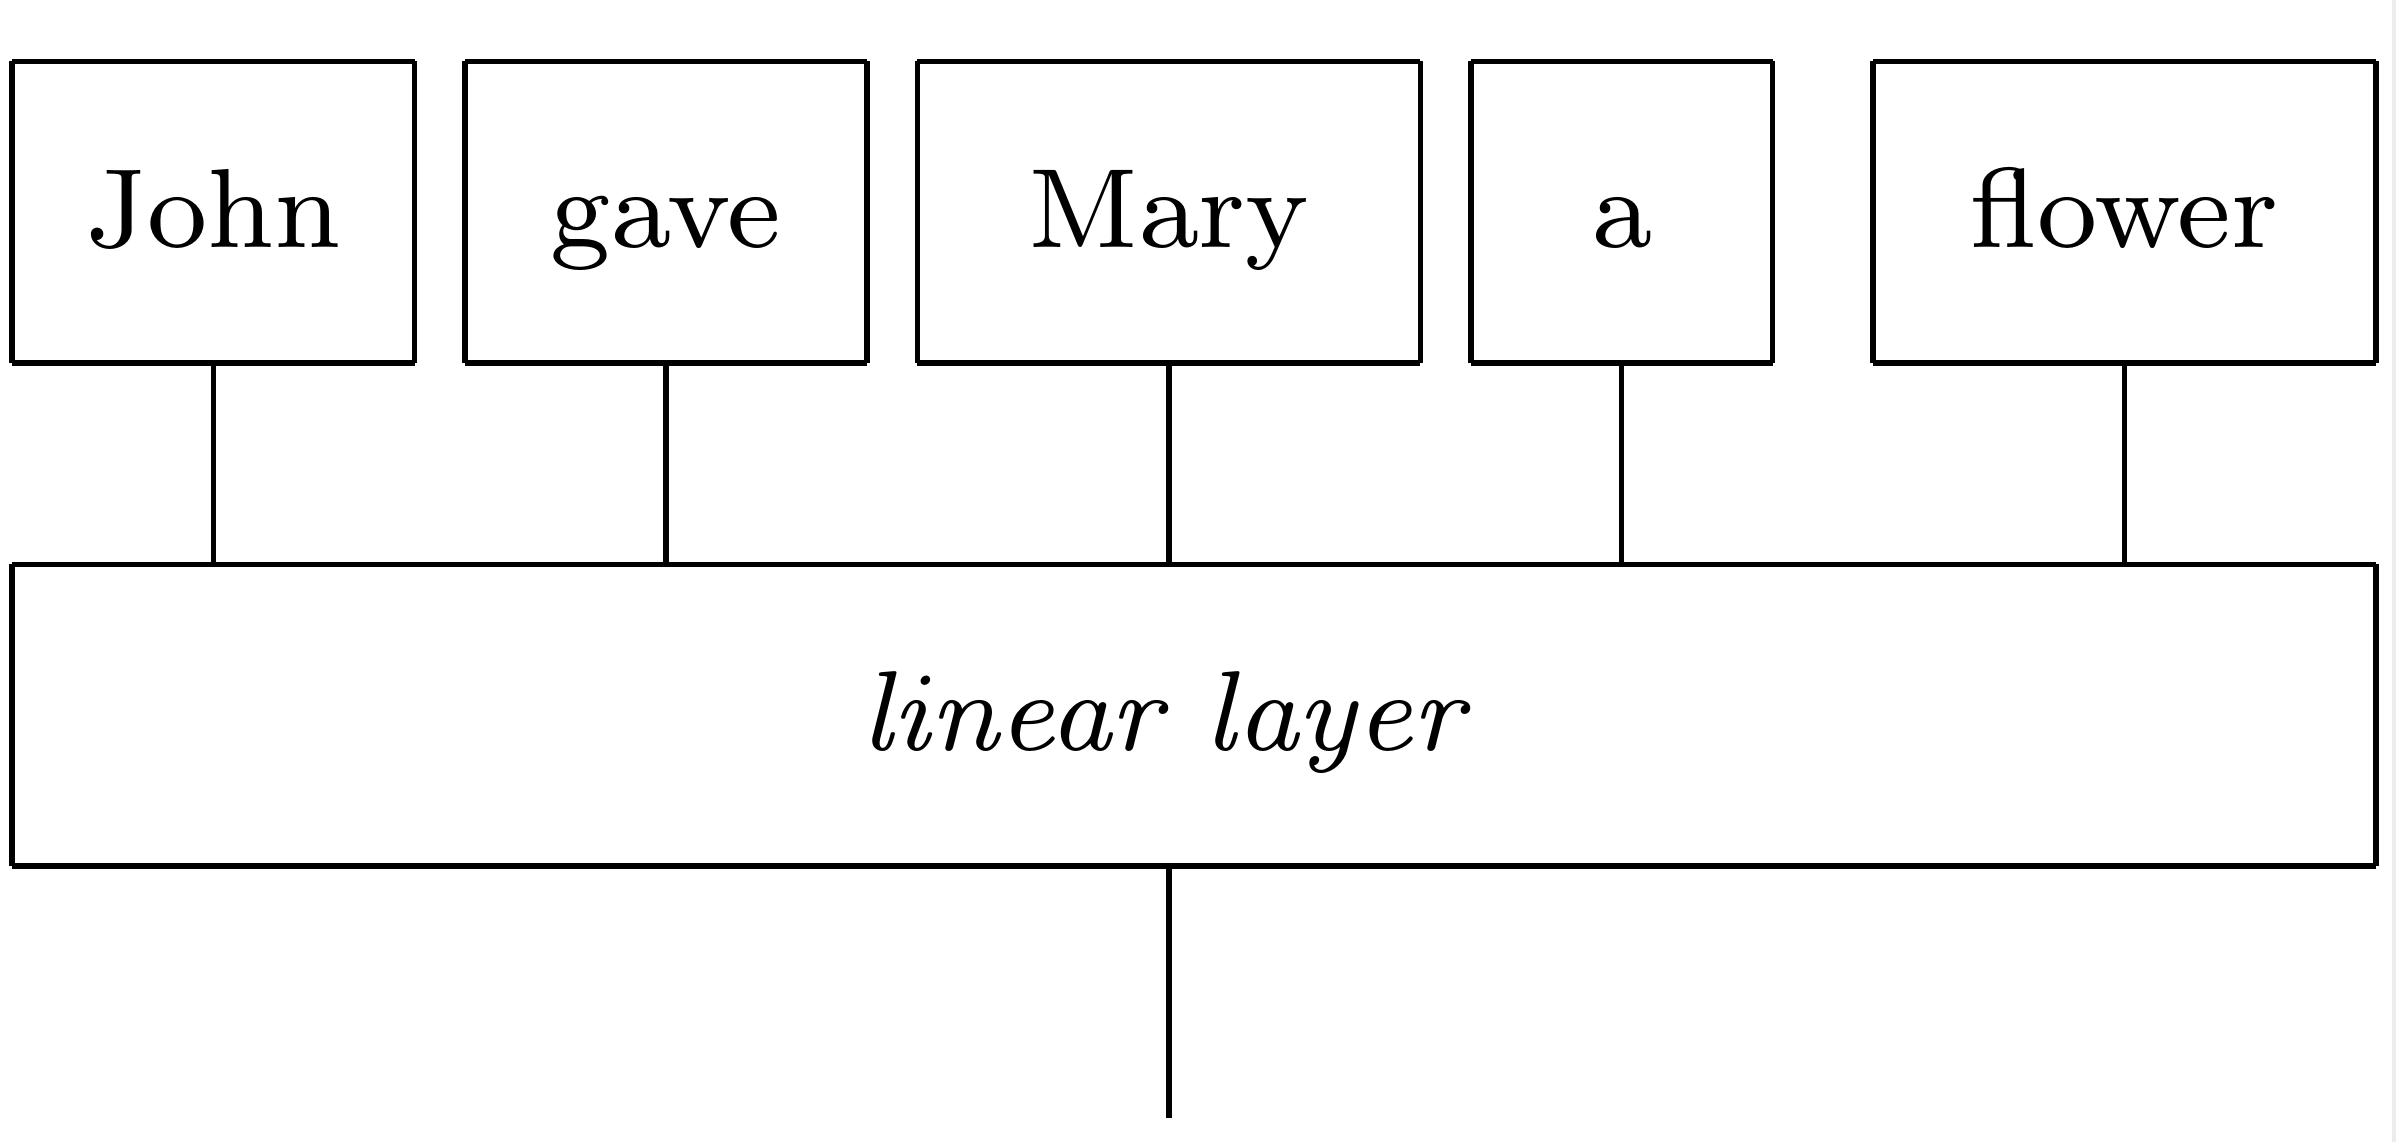
</center>

Note that the particular compositional model is not appropriate for classical experiments, since the tensor that implements the layer can become very large for long sentences. However, the model can be implemented without problems on a quantum computer.

/opt/miniconda3/envs/lambeq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


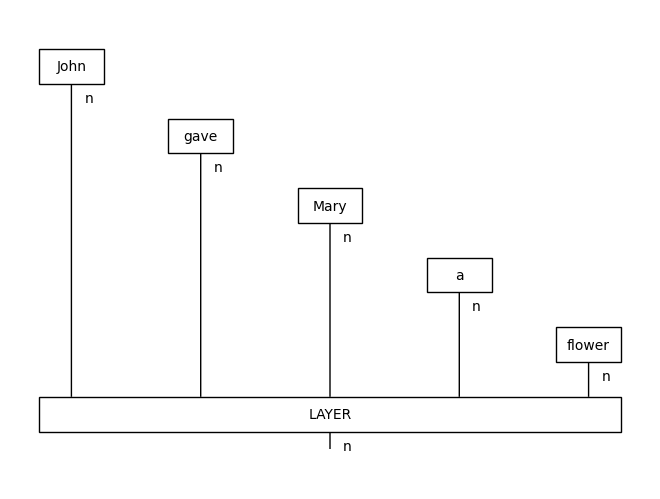

In [2]:
from lambeq import AtomicType, Reader
from discopy.grammar.pregroup import Box, Id, Word

N = AtomicType.NOUN

class CombReader(Reader):
    def sentence2diagram(self, sentence):
        words = Id().tensor(*[Word(w, N) for w in sentence.split()])
        layer = Box('LAYER', words.cod, N)
        return words >> layer

diagram = CombReader().sentence2diagram('John gave Mary a flower')
diagram.draw()

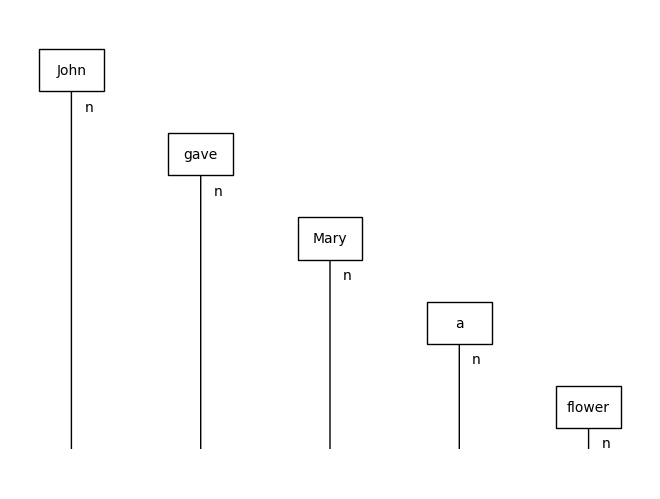

In [3]:
Id().tensor(*[Word(w, N) for w in ['John', 'gave', 'Mary', 'a', 'flower']]).draw()

## Creating rewrite rules

In [4]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')
d = parser.sentence2diagram('The food is fresh')

### SimpleRewriteRule example: Negation functor

In [5]:
from lambeq import AtomicType, SimpleRewriteRule

N = AtomicType.NOUN
S = AtomicType.SENTENCE
adj = N @ N.l

NOT = Box('NOT', S, S)

negation_rewrite = SimpleRewriteRule(
    cod=N.r @ S @ S.l @ N,
    template=SimpleRewriteRule.placeholder(N.r @ S @ S.l @ N) >> Id(N.r) @ NOT @ Id(S.l @ N),
    words=['is', 'was', 'has', 'have'])

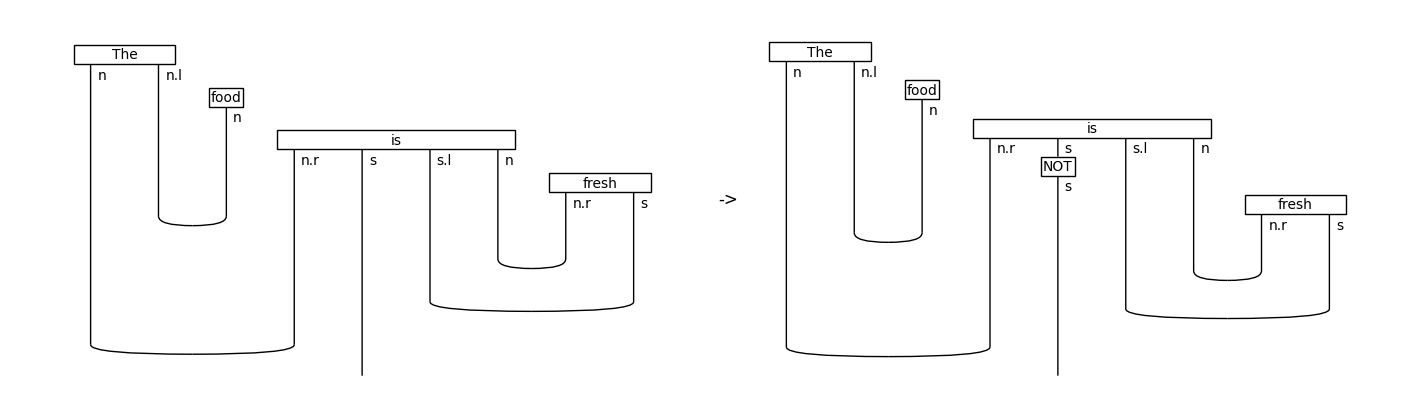

In [9]:
from lambeq import Rewriter
from discopy.drawing import Equation

not_d = Rewriter([negation_rewrite])(d)
Equation(d, not_d, symbol='->').draw(figsize=(14, 4))

### RewriteRule example: "Past" functor

In [10]:
from lambeq import RewriteRule

class PastRewriteRule(RewriteRule):
    mapping = {
        'is': 'was',
        'are': 'were',
        'has': 'had'
    }
    def matches(self, box):
        return box.name in self.mapping
    
    def rewrite(self, box):
        new_name = self.mapping[box.name]
        return type(box)(name=new_name, dom=box.dom, cod=box.cod)

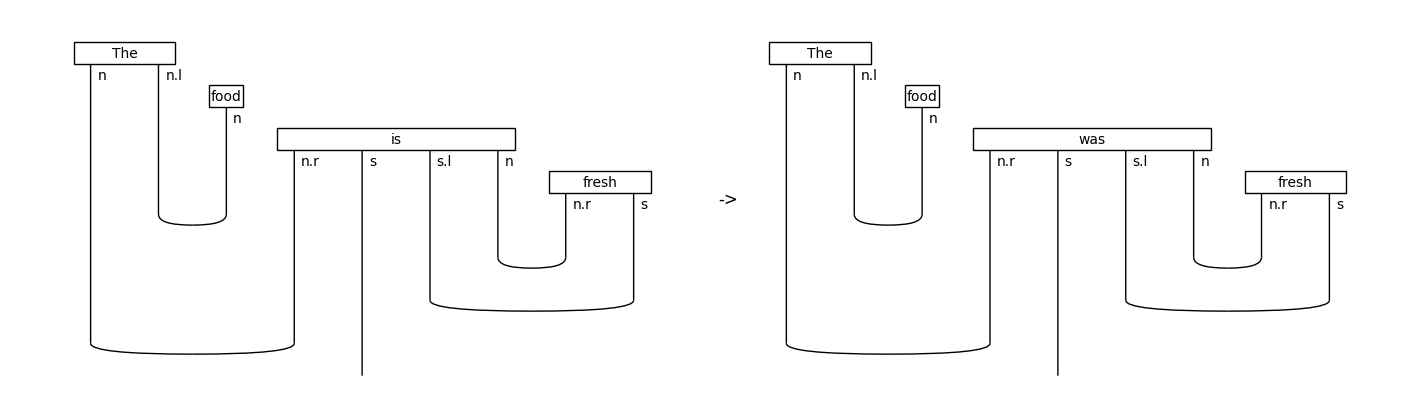

In [14]:
past_d = Rewriter([PastRewriteRule()])(d)
Equation(d, past_d, symbol='->').draw(figsize=(14, 4))

## Creating ansätze

In [15]:
d = parser.sentence2diagram('We will go')

### CircuitAnsatz example: "Real-valued" ansatz

In [16]:
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.gates import Bra, CX, Ket, Ry

from lambeq import CircuitAnsatz
    
def real_ansatz_circuit(n_qubits, params):

    circuit = Id(n_qubits)
    n_layers = params.shape[0]

    for i in range(n_layers):
        offset = i * n_qubits
        syms = params[i]

        # adds a ladder of CNOTs
        for j in range(n_qubits - 1):
            circuit >>= Id(j) @ CX @ Id(n_qubits - j - 2)

        # adds a layer of Y rotations
        circuit >>= Id().tensor(*[Ry(sym) for sym in syms])
    
    return circuit    


class RealAnsatz(CircuitAnsatz):
    def __init__(self, ob_map, n_layers, n_single_qubit_params = 1, discard = False):

        super().__init__(ob_map,
                         n_layers,
                         n_single_qubit_params,
                         real_ansatz_circuit,
                         discard,
                         [Ry, ])

    def params_shape(self, n_qubits):
        return (self.n_layers, n_qubits)

In [17]:
real_d = RealAnsatz({N: 1, S: 1}, n_layers=2)(d)
real_d.draw(figsize=(12, 10))

TypeError: Can't instantiate abstract class RealAnsatz with abstract method params_shape

### TensorAnsatz example: "Positive" ansatz

In [ ]:
from lambeq import TensorAnsatz, Symbol
from discopy import rigid, tensor
from functools import reduce
import math

class PositiveAnsatz(TensorAnsatz):

    def _ar(self, box):
        # step 1: obtain label
        label = self._summarise_box(box)

        # step 2: map domain and codomain
        dom, cod = self.functor(box.dom), self.functor(box.cod)

        # step 3: construct and return ansatz
        name = self._summarise_box(box)

        syms = Symbol(name, math.prod(dom), math.prod(cod))

        return tensor.Box(box.name, dom, cod, syms ** 2)

In [ ]:
from discopy.tensor import Dim

ansatz = PositiveAnsatz({N: Dim(2), S: Dim(2)})
positive_d = ansatz(d)
positive_d.draw()

In [ ]:
import numpy as np
from sympy import default_sort_key


syms = sorted(positive_d.free_symbols, key=default_sort_key)
sym_dict = {k: -np.ones(k.size) for k in syms}
subbed_diagram = positive_d.lambdify(*syms)(*sym_dict.values())

subbed_diagram.eval()

## Contributions